# Preprocessing - Basic feature selection

Before performing All Relevant Feature Selection, you might want to apply preprocessing or basic feature selection to remove columns with:

 - a lot of missing values
 - zero variance
 - high cardinality
 - highly correlated (and keep only one)
 - zero predictive power
 - low predictive power

Any of those steps can be ignored but I recommend at least removing highly correlated predictors if you don't have a good reason for keeping them in the dataset.


In [3]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))

In [1]:
# Settings and libraries
from __future__ import print_function

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import gc

import arfs
import arfs.preprocessing as arfspp
import arfs.feature_selection as arfsfs
from arfs.utils import (
    _make_corr_dataset_regression,
    _make_corr_dataset_classification,
)

In [2]:
print(f"Run with ARFS {arfs.__version__}")

Run with ARFS 3.0.0


In [3]:
arfsfs.__all__

['BaseThresholdSelector',
 'MissingValueThreshold',
 'UniqueValuesThreshold',
 'CardinalityThreshold',
 'CollinearityThreshold',
 'VariableImportance',
 'make_fs_summary',
 'Leshy',
 'BoostAGroota',
 'GrootCV',
 'MinRedundancyMaxRelevance',
 'LassoFeatureSelection']

Generating artificial data, inspired by the BorutaPy unit test

In [4]:
X, y, w = _make_corr_dataset_regression()
data = X.copy()
data["target"] = y

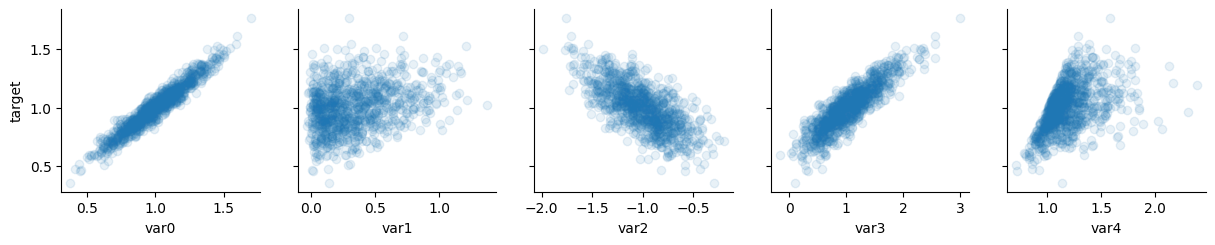

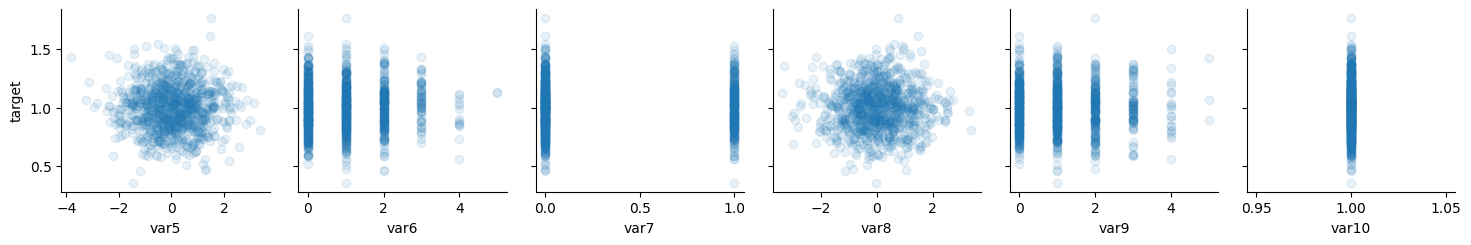

In [5]:
# significant regressors
x_vars = ["var0", "var1", "var2", "var3", "var4"]
y_vars = ["target"]
g = sns.PairGrid(data, x_vars=x_vars, y_vars=y_vars)
g.map(plt.scatter, alpha=0.1)

# noise
x_vars = ["var5", "var6", "var7", "var8", "var9", "var10"]
y_vars = ["target"]
g = sns.PairGrid(data, x_vars=x_vars, y_vars=y_vars)
g.map(plt.scatter, alpha=0.1)

plt.plot();

In [6]:
X.head()

,var0,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,nice_guys
0,1.016361,0.821664,-1.184095,0.985738,1.050445,-0.494190,2,0,-0.361717,1,1.0,0,1.705980,Bias
1,0.929581,0.334013,-1.063030,0.819273,1.016252,0.283845,1,0,0.178670,2,1.0,1,NaN,Klaue
2,1.095456,0.187234,-1.488666,1.087443,1.140542,0.962503,2,0,-3.375579,2,1.0,2,NaN,Imaginedragons
3,1.318165,0.994528,-1.370624,1.592398,1.315021,1.165595,0,0,-0.449650,2,1.0,3,2.929707,MarkZ
4,0.849496,0.184859,-0.806604,0.865702,0.991916,-0.058833,1,0,0.763903,1,1.0,4,NaN,Thanos


In [7]:
X.dtypes

var0          float64
var1          float64
var2          float64
var3          float64
var4          float64
var5          float64
var6            int64
var7            int64
var8          float64
var9            int64
var10         float64
var11        category
var12         float64
nice_guys      object
dtype: object

In [8]:
X.nunique()

var0         1000
var1         1000
var2         1000
var3         1000
var4         1000
var5         1000
var6            6
var7            2
var8         1000
var9            6
var10           1
var11         500
var12         500
nice_guys      36
dtype: int64

In [9]:
y = pd.Series(y)
y.name = "target"

## Removing columns with many missing values

In [10]:
# X is the predictor DF (e.g: df[predictor_list]), at this stage you don't need to
# specify the target and weights (only for identifying zero and low importance)

# unsupervised learning, doesn't need a target
selector = arfsfs.MissingValueThreshold(0.05)
X_trans = selector.fit_transform(X)
print(f"The features going in the selector are : {selector.feature_names_in_}")
print(f"The support is : {selector.support_}")
print(f"The selected features are : {selector.get_feature_names_out()}")

The features going in the selector are : ['var0' 'var1' 'var2' 'var3' 'var4' 'var5' 'var6' 'var7' 'var8' 'var9'
 'var10' 'var11' 'var12' 'nice_guys']
The support is : [ True  True  True  True  True  True  True  True  True  True  True  True
 False  True]
The selected features are : ['var0' 'var1' 'var2' 'var3' 'var4' 'var5' 'var6' 'var7' 'var8' 'var9'
 'var10' 'var11' 'nice_guys']


In [11]:
X_trans.head()

,var0,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,nice_guys
0,1.016361,0.821664,-1.184095,0.985738,1.050445,-0.494190,2,0,-0.361717,1,1.0,0,Bias
1,0.929581,0.334013,-1.063030,0.819273,1.016252,0.283845,1,0,0.178670,2,1.0,1,Klaue
2,1.095456,0.187234,-1.488666,1.087443,1.140542,0.962503,2,0,-3.375579,2,1.0,2,Imaginedragons
3,1.318165,0.994528,-1.370624,1.592398,1.315021,1.165595,0,0,-0.449650,2,1.0,3,MarkZ
4,0.849496,0.184859,-0.806604,0.865702,0.991916,-0.058833,1,0,0.763903,1,1.0,4,Thanos


In [12]:
X.head()

,var0,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,nice_guys
0,1.016361,0.821664,-1.184095,0.985738,1.050445,-0.494190,2,0,-0.361717,1,1.0,0,1.705980,Bias
1,0.929581,0.334013,-1.063030,0.819273,1.016252,0.283845,1,0,0.178670,2,1.0,1,NaN,Klaue
2,1.095456,0.187234,-1.488666,1.087443,1.140542,0.962503,2,0,-3.375579,2,1.0,2,NaN,Imaginedragons
3,1.318165,0.994528,-1.370624,1.592398,1.315021,1.165595,0,0,-0.449650,2,1.0,3,2.929707,MarkZ
4,0.849496,0.184859,-0.806604,0.865702,0.991916,-0.058833,1,0,0.763903,1,1.0,4,NaN,Thanos


## Removing columns with zero variance

In [13]:
# single unique value(s) columns
# here rejecting columns with (or less than) 2 unique values
# unsupervised learning, doesn't need a target
selector = arfsfs.UniqueValuesThreshold(threshold=2)
X_trans = selector.fit_transform(X)
print(f"The features going in the selector are : {selector.feature_names_in_}")
print(f"The support is : {selector.support_}")
print(f"The selected features are : {selector.get_feature_names_out()}")

The features going in the selector are : ['var0' 'var1' 'var2' 'var3' 'var4' 'var5' 'var6' 'var7' 'var8' 'var9'
 'var10' 'var11' 'var12' 'nice_guys']
The support is : [ True  True  True  True  True  True  True False  True  True False  True
  True  True]
The selected features are : ['var0' 'var1' 'var2' 'var3' 'var4' 'var5' 'var6' 'var8' 'var9' 'var11'
 'var12' 'nice_guys']


In [14]:
X_trans.head()

,var0,var1,var2,var3,var4,var5,var6,var8,var9,var11,var12,nice_guys
0,1.016361,0.821664,-1.184095,0.985738,1.050445,-0.494190,2,-0.361717,1,0,1.705980,Bias
1,0.929581,0.334013,-1.063030,0.819273,1.016252,0.283845,1,0.178670,2,1,NaN,Klaue
2,1.095456,0.187234,-1.488666,1.087443,1.140542,0.962503,2,-3.375579,2,2,NaN,Imaginedragons
3,1.318165,0.994528,-1.370624,1.592398,1.315021,1.165595,0,-0.449650,2,3,2.929707,MarkZ
4,0.849496,0.184859,-0.806604,0.865702,0.991916,-0.058833,1,0.763903,1,4,NaN,Thanos


In [15]:
X.head()

,var0,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,nice_guys
0,1.016361,0.821664,-1.184095,0.985738,1.050445,-0.494190,2,0,-0.361717,1,1.0,0,1.705980,Bias
1,0.929581,0.334013,-1.063030,0.819273,1.016252,0.283845,1,0,0.178670,2,1.0,1,NaN,Klaue
2,1.095456,0.187234,-1.488666,1.087443,1.140542,0.962503,2,0,-3.375579,2,1.0,2,NaN,Imaginedragons
3,1.318165,0.994528,-1.370624,1.592398,1.315021,1.165595,0,0,-0.449650,2,1.0,3,2.929707,MarkZ
4,0.849496,0.184859,-0.806604,0.865702,0.991916,-0.058833,1,0,0.763903,1,1.0,4,NaN,Thanos


## Removing columns with high cardinality

Large cardinality or many unique values are known to be favoured by tree-based models.

In [16]:
# high cardinality for categoricals predictors
# unsupervised learning, doesn't need a target
selector = arfsfs.CardinalityThreshold(threshold=100)
X_trans = selector.fit_transform(X)
print(f"The features going in the selector are : {selector.feature_names_in_}")
print(f"The support is : {selector.support_}")
print(f"The selected features are : {selector.get_feature_names_out()}")

The features going in the selector are : ['var0' 'var1' 'var2' 'var3' 'var4' 'var5' 'var6' 'var7' 'var8' 'var9'
 'var10' 'var11' 'var12' 'nice_guys']
The support is : [ True  True  True  True  True  True  True  True  True  True  True False
  True  True]
The selected features are : ['var0' 'var1' 'var2' 'var3' 'var4' 'var5' 'var6' 'var7' 'var8' 'var9'
 'var10' 'var12' 'nice_guys']


In [17]:
X_trans.head()

,var0,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var12,nice_guys
0,1.016361,0.821664,-1.184095,0.985738,1.050445,-0.494190,2,0,-0.361717,1,1.0,1.705980,Bias
1,0.929581,0.334013,-1.063030,0.819273,1.016252,0.283845,1,0,0.178670,2,1.0,NaN,Klaue
2,1.095456,0.187234,-1.488666,1.087443,1.140542,0.962503,2,0,-3.375579,2,1.0,NaN,Imaginedragons
3,1.318165,0.994528,-1.370624,1.592398,1.315021,1.165595,0,0,-0.449650,2,1.0,2.929707,MarkZ
4,0.849496,0.184859,-0.806604,0.865702,0.991916,-0.058833,1,0,0.763903,1,1.0,NaN,Thanos


In [18]:
X.head()

,var0,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,nice_guys
0,1.016361,0.821664,-1.184095,0.985738,1.050445,-0.494190,2,0,-0.361717,1,1.0,0,1.705980,Bias
1,0.929581,0.334013,-1.063030,0.819273,1.016252,0.283845,1,0,0.178670,2,1.0,1,NaN,Klaue
2,1.095456,0.187234,-1.488666,1.087443,1.140542,0.962503,2,0,-3.375579,2,1.0,2,NaN,Imaginedragons
3,1.318165,0.994528,-1.370624,1.592398,1.315021,1.165595,0,0,-0.449650,2,1.0,3,2.929707,MarkZ
4,0.849496,0.184859,-0.806604,0.865702,0.991916,-0.058833,1,0,0.763903,1,1.0,4,NaN,Thanos


## Removing columns highly correlated

REM: if the matrix is not of full rank (as with a constant column), warnings will be printed.

In [19]:
# unsupervised learning, doesn't need a target
selector = arfsfs.CollinearityThreshold(threshold=0.85, n_jobs=1)
X_trans = selector.fit_transform(X)
print(f"The features going in the selector are : {selector.feature_names_in_}")
print(f"The support is : {selector.support_}")
print(f"The selected features are : {selector.get_feature_names_out()}")

/home/bsatom/Documents/arfs/src/arfs/association.py:2008: UserWarning: {'var10'} columns have been removed (single unique values)
  warnings.warn(
/home/bsatom/Documents/arfs/src/arfs/association.py:802: RuntimeWarning: invalid value encountered in scalar divide
  return wcov(x, y, w) / np.sqrt(wcov(x, x, w) * wcov(y, y, w))


The features going in the selector are : ['var0' 'var1' 'var2' 'var3' 'var4' 'var5' 'var6' 'var7' 'var8' 'var9'
 'var10' 'var11' 'var12' 'nice_guys']
The support is : [ True  True  True  True  True  True  True  True  True  True  True False
  True  True]
The selected features are : ['var0' 'var1' 'var2' 'var3' 'var4' 'var5' 'var6' 'var7' 'var8' 'var9'
 'var10' 'var12' 'nice_guys']


In [20]:
selector.assoc_matrix_

,nice_guys,var0,var1,var10,var11,var12,var2,var3,var4,var5,var6,var7,var8,var9
nice_guys,0.000000,0.294977,0.258632,0.0,0.898225,0.280449,0.248837,0.304239,0.310595,0.246047,0.239888,0.349974,0.260776,0.229026
var0,0.294977,0.000000,0.282736,0.0,0.854820,0.670104,-0.640341,0.835490,0.504859,0.019782,0.075779,-0.006975,0.004806,-0.071982
var1,0.258632,0.282736,0.000000,0.0,0.868096,0.217412,-0.183097,0.219186,0.173907,0.052066,0.075403,-0.014381,0.038794,0.014512
var10,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
var11,0.544415,0.854820,0.868096,0.0,0.000000,0.849764,0.872079,0.847803,0.838437,0.868140,0.865499,0.879649,0.873458,0.857720
var12,0.280449,0.670104,0.217412,0.0,0.849764,0.000000,-0.510784,0.636771,0.343434,-0.012044,-0.002185,0.017146,0.051422,-0.030705
var2,0.248837,-0.640341,-0.183097,0.0,0.872079,-0.510784,0.000000,-0.578976,-0.349124,-0.017457,-0.088786,-0.068554,0.013565,-0.009740
var3,0.304239,0.835490,0.219186,0.0,0.847803,0.636771,-0.578976,0.000000,0.484142,0.017808,0.045680,-0.034692,-0.012920,-0.047775
var4,0.310595,0.504859,0.173907,0.0,0.838437,0.343434,-0.349124,0.484142,0.000000,-0.022485,0.077745,-0.063761,0.003185,-0.023237
var5,0.246047,0.019782,0.052066,0.0,0.868140,-0.012044,-0.017457,0.017808,-0.022485,0.000000,0.088044,-0.022401,0.017256,-0.053119


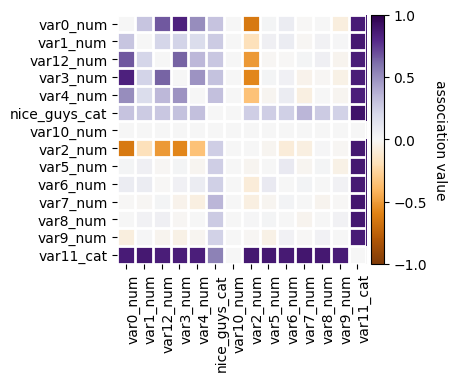

In [21]:
f = selector.plot_association()

  * the Correlation Ratio, for categorical-continuous association. Answers the question - given a continuous value of a measurement, is it possible to know which category is it associated with? Value is in the range $[0,1]$, where 0 means a category cannot be determined by a continuous measurement, and 1 means a category can be determined with absolute certainty
  * Calculates Theil's U statistic (Uncertainty coefficient) for categorical-categorical association. This is the uncertainty of x given y: value is on the range of $[0,1]$ - where 0 means y provides no information about x, and 1 means y provides full information about x. This is an asymmetric coefficient: $U(x,y) \neq U(y,x)$

In [22]:
selector.assoc_matrix_.loc[:, selector.not_selected_features_]

,var11
nice_guys,0.898225
var0,0.854820
var1,0.868096
var10,0.000000
var11,0.000000
var12,0.849764
var2,0.872079
var3,0.847803
var4,0.838437
var5,0.868140


In [23]:
X.shape

(1000, 14)

## Removing columns with zero or low predictive power

Identify the features with zero importance according to a gradient boosting machine. The lightgbm can be trained with early stopping using a utils set to prevent overfitting. The feature importances are averaged over `n_iterations` to reduce variance. Shapley values are used as feature importance for better results. If some predictors need to be encoded, integer encoding is chosen because OHE might lead to deep and unstable trees and lightGBM works great with integer encoding (see lightGBM doc).

In [24]:
lgb_kwargs = {"objective": "rmse", "zero_as_missing": False}
selector = arfsfs.VariableImportance(
    verbose=2, threshold=0.99, lgb_kwargs=lgb_kwargs, fastshap=False
)
X_trans = selector.fit_transform(X=X, y=y, sample_weight=w)
print(f"The features going in the selector are : {selector.feature_names_in_}")
print(f"The support is : {selector.support_}")
print(f"The selected features are : {selector.get_feature_names_out()}")

  0%|          | 0/10 [00:00<?, ?it/s]

Data split: Train=800 samples, Validation=200 samples.
No 'metric' provided, using objective 'rmse' as metric.
Training up to 10000 boosting rounds.


Data split: Train=800 samples, Validation=200 samples.
No 'metric' provided, using objective 'rmse' as metric.
Training up to 10000 boosting rounds.
Data split: Train=800 samples, Validation=200 samples.
No 'metric' provided, using objective 'rmse' as metric.
Training up to 10000 boosting rounds.
Data split: Train=800 samples, Validation=200 samples.
No 'metric' provided, using objective 'rmse' as metric.
Training up to 10000 boosting rounds.
Data split: Train=800 samples, Validation=200 samples.
No 'metric' provided, using objective 'rmse' as metric.
Training up to 10000 boosting rounds.
Data split: Train=800 samples, Validation=200 samples.
No 'metric' provided, using objective 'rmse' as metric.
Training up to 10000 boosting rounds.
Data split: Train=800 samples, Validation=200 samples.
No 'metric' provided, using objective 'rmse' as metric.
Training up to 10000 boosting rounds.
Data split: Train=800 samples, Validation=200 samples.
No 'metric' provided, using objective 'rmse' as met

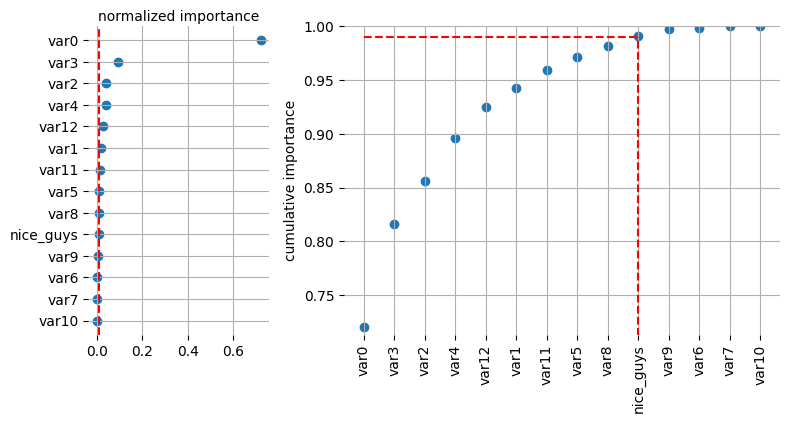

In [25]:
selector.plot_importance(log=False, style=None)

enable [fasttreeshap](https://engineering.linkedin.com/blog/2022/fasttreeshap--accelerating-shap-value-computation-for-trees) implementation

In [26]:
lgb_kwargs = {"objective": "rmse", "zero_as_missing": False}
selector = arfsfs.VariableImportance(
    verbose=2, threshold=0.99, lgb_kwargs=lgb_kwargs, fastshap=True
)
X_trans = selector.fit_transform(X=X, y=y, sample_weight=w)
print(f"The features going in the selector are : {selector.feature_names_in_}")
print(f"The support is : {selector.support_}")
print(f"The selected features are : {selector.get_feature_names_out()}")

  0%|          | 0/10 [00:00<?, ?it/s]

Data split: Train=800 samples, Validation=200 samples.
No 'metric' provided, using objective 'rmse' as metric.
Training up to 10000 boosting rounds.


UnboundLocalError: cannot access local variable 'FastTreeExplainer' where it is not associated with a value

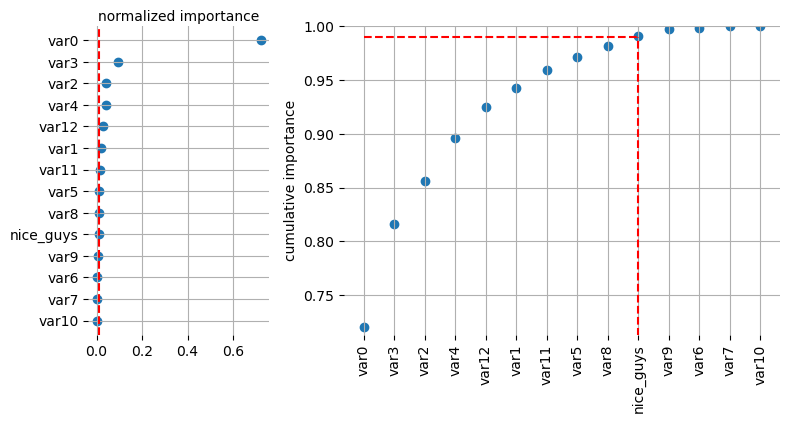

In [ ]:
selector.plot_importance(log=False, style=None)

## All at once - Sklearn Pipeline

The selectors follow the scikit-learn base class, therefore they are compatible with scikit-learn in general.
This has several advantages:
 - easier to maintain
 - easier to version
 - more flexible
 - running faster by removing unnecessary columns before going to the computational demanding steps


In [27]:
from arfs.preprocessing import dtype_column_selector

cat_features_selector = dtype_column_selector(
    dtype_include=["category", "object", "bool"],
    dtype_exclude=[np.number],
    pattern=None,
    exclude_cols=["nice_guys"],
)

cat_features_selector(X)

['var11']

In [28]:
from sklearn.pipeline import Pipeline
from arfs.preprocessing import OrdinalEncoderPandas

encoder = Pipeline(
    [
        ("zero_variance", arfsfs.UniqueValuesThreshold()),
        ("collinearity", arfsfs.CollinearityThreshold(threshold=0.75)),
        ("encoder", OrdinalEncoderPandas()),
    ]
)
X_encoded = encoder.fit(X).transform(X)

In [29]:
encoder.fit(X)

Pipeline(steps=[('zero_variance', UniqueValuesThreshold()),
                ('collinearity', CollinearityThreshold(threshold=0.75)),
                ('encoder', OrdinalEncoderPandas())])

In [30]:
X_encoded = OrdinalEncoderPandas().fit_transform(X)
X_encoded

,var0,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,nice_guys
0,1.016361,0.821664,-1.184095,0.985738,1.050445,-0.494190,2,0,-0.361717,1,1.0,0.0,1.705980,4.0
1,0.929581,0.334013,-1.063030,0.819273,1.016252,0.283845,1,0,0.178670,2,1.0,1.0,NaN,21.0
2,1.095456,0.187234,-1.488666,1.087443,1.140542,0.962503,2,0,-3.375579,2,1.0,2.0,NaN,19.0
3,1.318165,0.994528,-1.370624,1.592398,1.315021,1.165595,0,0,-0.449650,2,1.0,3.0,2.929707,25.0
4,0.849496,0.184859,-0.806604,0.865702,0.991916,-0.058833,1,0,0.763903,1,1.0,4.0,NaN,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.904073,0.009764,-0.909486,0.831147,1.041658,0.081291,0,0,-0.542799,3,1.0,495.0,NaN,10.0
996,1.370908,1.144173,-1.129008,2.002148,1.418488,0.484591,0,1,-1.932372,1,1.0,496.0,2.587139,0.0
997,1.113773,0.206798,-1.371649,1.167287,1.079760,0.267475,0,0,-0.329798,0,1.0,497.0,3.880225,17.0
998,0.905654,0.598419,-0.792174,0.783557,1.275266,0.380826,1,0,-1.987310,1,1.0,498.0,1.888725,17.0


In [31]:
basic_fs_pipeline = Pipeline(
    [
        ("missing", arfsfs.MissingValueThreshold(threshold=0.05)),
        ("unique", arfsfs.UniqueValuesThreshold(threshold=1)),
        ("cardinality", arfsfs.CardinalityThreshold(threshold=10)),
        ("collinearity", arfsfs.CollinearityThreshold(threshold=0.75)),
        ("encoder", OrdinalEncoderPandas()),
        (
            "lowimp",
            arfsfs.VariableImportance(
                verbose=2, threshold=0.99, lgb_kwargs=lgb_kwargs, encode=False
            ),
        ),
    ]
)

X_trans = basic_fs_pipeline.fit_transform(
    X=X, y=y, collinearity__sample_weight=w, lowimp__sample_weight=w
)

  0%|          | 0/10 [00:00<?, ?it/s]

Data split: Train=800 samples, Validation=200 samples.
No 'metric' provided, using objective 'rmse' as metric.
Training up to 10000 boosting rounds.
Data split: Train=800 samples, Validation=200 samples.
No 'metric' provided, using objective 'rmse' as metric.
Training up to 10000 boosting rounds.
Data split: Train=800 samples, Validation=200 samples.
No 'metric' provided, using objective 'rmse' as metric.
Training up to 10000 boosting rounds.
Data split: Train=800 samples, Validation=200 samples.
No 'metric' provided, using objective 'rmse' as metric.
Training up to 10000 boosting rounds.
Data split: Train=800 samples, Validation=200 samples.
No 'metric' provided, using objective 'rmse' as metric.
Training up to 10000 boosting rounds.
Data split: Train=800 samples, Validation=200 samples.
No 'metric' provided, using objective 'rmse' as metric.
Training up to 10000 boosting rounds.
Data split: Train=800 samples, Validation=200 samples.
No 'metric' provided, using objective 'rmse' as met

In [32]:
basic_fs_pipeline

Pipeline(steps=[('missing', MissingValueThreshold()),
                ('unique', UniqueValuesThreshold()),
                ('cardinality', CardinalityThreshold(threshold=10)),
                ('collinearity', CollinearityThreshold(threshold=0.75)),
                ('encoder', OrdinalEncoderPandas()),
                ('lowimp', VariableImportance(encode=False, verbose=2))])

In [33]:
# X_trans = basic_fs_pipeline.transform(X)
X_trans.head()

,var1,var2,var3,var4,var5,var8
0,0.821664,-1.184095,0.985738,1.050445,-0.494190,-0.361717
1,0.334013,-1.063030,0.819273,1.016252,0.283845,0.178670
2,0.187234,-1.488666,1.087443,1.140542,0.962503,-3.375579
3,0.994528,-1.370624,1.592398,1.315021,1.165595,-0.449650
4,0.184859,-0.806604,0.865702,0.991916,-0.058833,0.763903


In [34]:
type(basic_fs_pipeline.named_steps["encoder"])

arfs.preprocessing.OrdinalEncoderPandas

In [35]:
arfsfs.make_fs_summary(basic_fs_pipeline)

/home/bsatom/Documents/arfs/src/arfs/feature_selection/summary.py:69: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: "" if x == x else "background-color: #f57505")


,predictor,missing,unique,cardinality,collinearity,encoder,lowimp
0,var0,1,1,1,0,nan,nan
1,var1,1,1,1,1,nan,1
2,var2,1,1,1,1,nan,1
3,var3,1,1,1,1,nan,1
4,var4,1,1,1,1,nan,1
5,var5,1,1,1,1,nan,1
6,var6,1,1,1,1,nan,0
7,var7,1,1,1,1,nan,0
8,var8,1,1,1,1,nan,1
9,var9,1,1,1,1,nan,0


Using the cancer data

ARFS version 3.0.0
The features going in the selector are : ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension'
 'random_num1' 'random_num2' 'genuine_num']
The support is : [False  True False  True  True False False  True  True  True  True  True
 False False  True False  True  True  True  True False False False False
  True  True False False  True  True  True  True  True]
The selected features are : ['mean texture' 'mean area' 'mean smoothness' 'mean concave points'
 'mean symmetry' 'mean frac

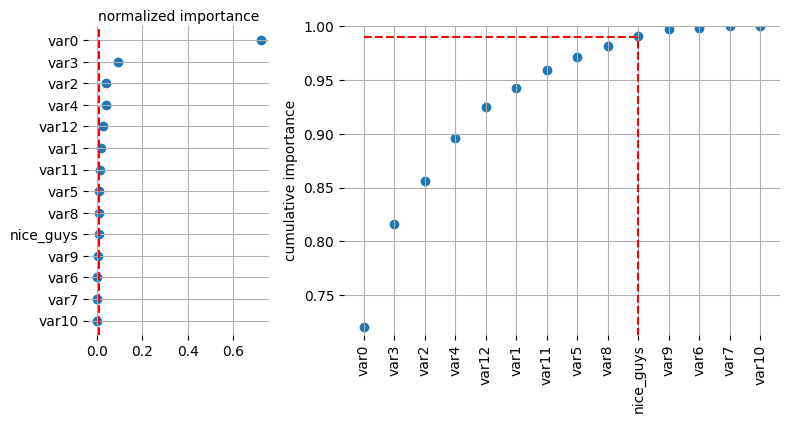

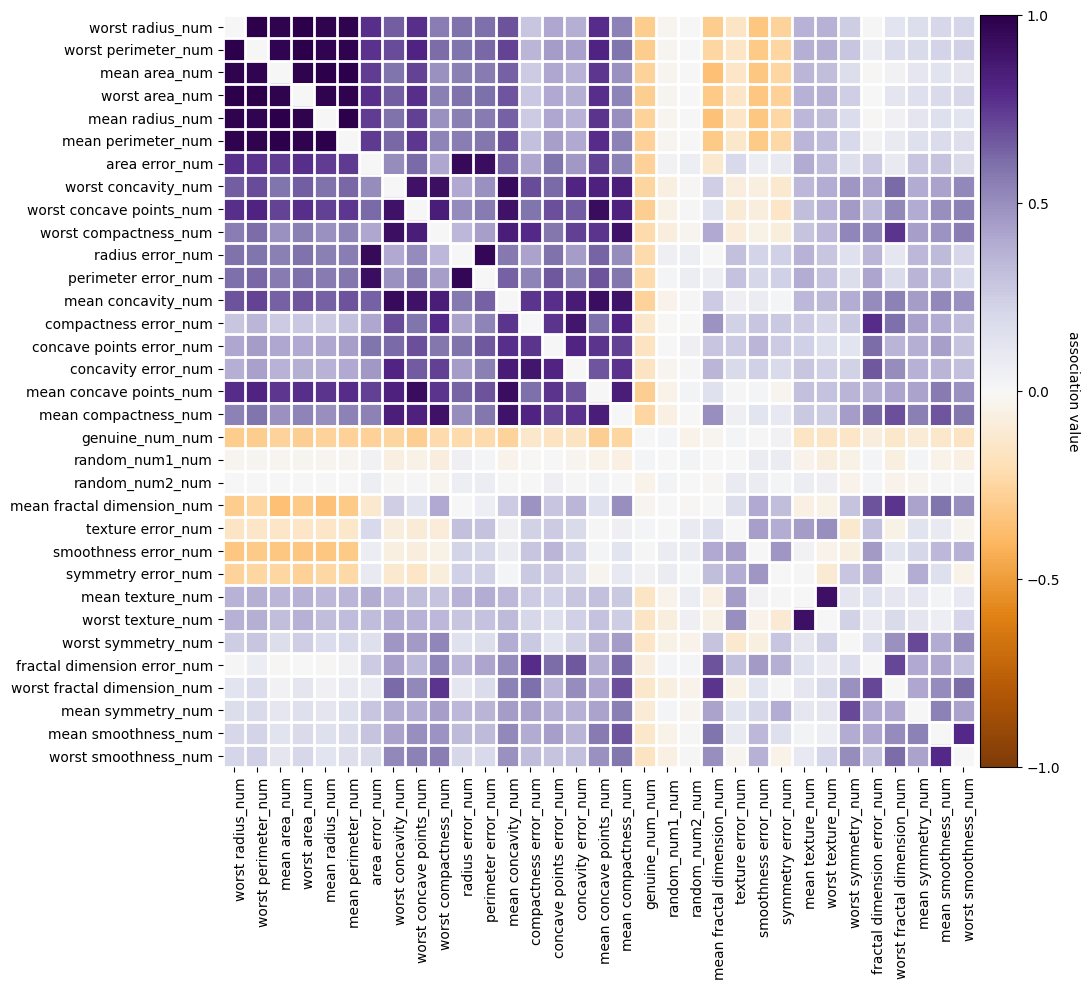

In [36]:
import arfs

print(f"ARFS version {arfs.__version__}")

from arfs.utils import load_data

cancer = load_data(name="cancer")
X, y = cancer.data, cancer.target
y = y.astype(int)

selector = arfsfs.CollinearityThreshold(threshold=0.85, n_jobs=1)
X_trans = selector.fit_transform(X)
print(f"The features going in the selector are : {selector.feature_names_in_}")
print(f"The support is : {selector.support_}")
print(f"The selected features are : {selector.get_feature_names_out()}")

f = selector.plot_association()

In [37]:
selector.not_selected_features_

array(['mean radius', 'mean perimeter', 'mean compactness',
       'mean concavity', 'perimeter error', 'area error',
       'compactness error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst concavity',
       'worst concave points'], dtype=object)

Association of the non-selected features with all the input features

In [38]:
def highlight_gt_threshold(v, props="", threshold=0.85):
    return props if v > threshold else None


selector.assoc_matrix_.loc[:, selector.not_selected_features_].style.applymap(
    highlight_gt_threshold, props="color:red;", threshold=0.85
)

/tmp/ipykernel_835068/2224511565.py:6: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  ].style.applymap(highlight_gt_threshold, props='color:red;', threshold=0.85)


,mean radius,mean perimeter,mean compactness,mean concavity,perimeter error,area error,compactness error,worst radius,worst texture,worst perimeter,worst area,worst concavity,worst concave points
area error,0.738077,0.745824,0.539511,0.644344,0.926937,0.000000,0.409830,0.774244,0.327857,0.768336,0.775662,0.500307,0.619539
compactness error,0.264904,0.308620,0.817875,0.761230,0.532081,0.409830,0.000000,0.285413,0.209979,0.344865,0.278844,0.701251,0.587471
concave points error,0.410576,0.441996,0.732425,0.774656,0.669574,0.588749,0.764150,0.410221,0.157304,0.448363,0.403587,0.624555,0.692071
concavity error,0.364555,0.402277,0.772283,0.858306,0.547805,0.461359,0.880965,0.381860,0.235945,0.432895,0.377836,0.811327,0.656814
fractal dimension error,-0.008411,0.032429,0.621121,0.513593,0.420114,0.259401,0.781396,0.013324,0.083174,0.063012,0.007312,0.431677,0.331206
genuine_num,-0.257916,-0.266154,-0.244416,-0.265017,-0.220325,-0.268824,-0.137252,-0.289229,-0.151634,-0.290689,-0.287949,-0.253526,-0.285553
mean area,0.999602,0.997068,0.488988,0.642557,0.568237,0.741518,0.260362,0.979258,0.318178,0.971822,0.980264,0.593736,0.723390
mean compactness,0.497578,0.543925,0.000000,0.896518,0.583520,0.539511,0.817875,0.542626,0.255305,0.592254,0.531590,0.837921,0.825473
mean concave points,0.759702,0.788629,0.848295,0.927352,0.679841,0.726982,0.608388,0.787411,0.300562,0.813960,0.780395,0.827281,0.937075
mean concavity,0.645728,0.681958,0.896518,0.000000,0.646199,0.644344,0.761230,0.682316,0.335866,0.722424,0.676628,0.938543,0.904938


Association of the selected features only

In [39]:
selector.assoc_matrix_.loc[
    selector.selected_features_, selector.selected_features_
].style.applymap(highlight_gt_threshold, props="color:red;", threshold=0.85)

/tmp/ipykernel_835068/2091193790.py:3: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  ].style.applymap(highlight_gt_threshold, props='color:red;', threshold=0.85)


,mean texture,mean area,mean smoothness,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,smoothness error,concavity error,concave points error,symmetry error,fractal dimension error,worst smoothness,worst compactness,worst symmetry,worst fractal dimension,random_num1,random_num2,genuine_num
mean texture,0.000000,0.344145,0.024649,0.306891,0.110130,-0.059303,0.363621,0.450720,0.037048,0.287188,0.238610,0.008945,0.147605,0.101401,0.290917,0.120693,0.116144,-0.033471,0.063706,-0.148910
mean area,0.344145,0.000000,0.138053,0.755165,0.113928,-0.358425,0.553388,-0.142469,-0.327431,0.362308,0.406468,-0.243507,-0.012688,0.119712,0.485813,0.170860,0.038758,-0.020784,0.000305,-0.258352
mean smoothness,0.024649,0.138053,0.000000,0.565172,0.542228,0.588465,0.334282,0.091283,0.338692,0.354730,0.438826,0.150740,0.413429,0.796085,0.481384,0.393579,0.511457,-0.043211,0.008687,-0.137660
mean concave points,0.306891,0.755165,0.565172,0.000000,0.423767,0.142659,0.635054,0.008710,0.016798,0.674668,0.758438,-0.028353,0.378374,0.490035,0.758309,0.355477,0.421110,-0.039682,0.025712,-0.288981
mean symmetry,0.110130,0.113928,0.542228,0.423767,0.000000,0.428467,0.337912,0.139124,0.206106,0.367637,0.382736,0.384123,0.402630,0.424230,0.440828,0.710359,0.410069,0.017243,-0.016538,-0.096999
mean fractal dimension,-0.059303,-0.358425,0.588465,0.142659,0.428467,0.000000,0.001477,0.157103,0.401530,0.344007,0.286393,0.314165,0.683800,0.493474,0.403653,0.295046,0.760771,0.001102,-0.012412,-0.019863
radius error,0.363621,0.553388,0.334282,0.635054,0.337912,0.001477,0.000000,0.309672,0.223469,0.452542,0.595594,0.240118,0.348164,0.203760,0.339725,0.147213,0.111043,0.054287,0.059528,-0.224582
texture error,0.450720,-0.142469,0.091283,0.008710,0.139124,0.157103,0.309672,0.000000,0.443640,0.189277,0.261263,0.389080,0.309209,-0.023095,-0.090069,-0.119890,-0.048143,0.000659,0.082678,0.021685
smoothness error,0.037048,-0.327431,0.338692,0.016798,0.206106,0.401530,0.223469,0.443640,0.000000,0.236961,0.345073,0.473579,0.460478,0.372247,-0.049245,-0.067149,0.129752,0.076456,0.075758,0.010950
concavity error,0.287188,0.362308,0.354730,0.674668,0.367637,0.344007,0.452542,0.189277,0.236961,0.000000,0.804773,0.191862,0.668224,0.305368,0.731517,0.230690,0.505962,-0.024256,0.014859,-0.161208


In [40]:
%timeit -n1 pass
res = arfs.association.wcorr_matrix(
    X, sample_weight=None, n_jobs=-1, handle_na="drop", method="pearson"
)

313 ns ± 280 ns per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
%timeit -n1 pass
from scipy import stats

res = stats.spearmanr(X)

253 ns ± 188 ns per loop (mean ± std. dev. of 7 runs, 1 loop each)
